In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from cereeberus import ReebGraph, MapperGraph, Interleave
import cereeberus.data.ex_mappergraphs as ex_mg

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.manifold import MDS

In [4]:
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import kmapper as km
from sklearn.cluster import DBSCAN
import networkx as nx
import multiprocessing as mp
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from itertools import combinations_with_replacement
import multiprocessing as mp

from cereeberus import Interleave, ReebGraph
import image_mapper_comparison as imc

In [5]:
def get_point_cloud_from_image(image_path, rotate_angle=None):

   # Load the image and resize it
    image = Image.open(image_path).convert('L') # Convert to grayscale
    

    # Rotate the image
    if rotate_angle is not None:
        image = image.rotate(rotate_angle)

    # Convert to numpy array
    image = np.array(image) 

    # get what the maximum pixel values are
    max_pixel = np.max(image)

    # save where the white pixels are and save that point cloud
    points = np.column_stack(np.where(image == max_pixel))

    return points

def save_rotated_image(image_path, rotate_angle):
    image = Image.open(image_path).convert('L') 
    image = image.rotate(rotate_angle, expand=True)
    image.save(image_path)

In [6]:
def image_kmapper(points):

    mapper = km.KeplerMapper(verbose=False)

    lens = mapper.project(points, projection=[1], scaler= None)

    graph = mapper.map(lens, points,
                       clusterer=DBSCAN(eps=3), 
                                        cover =km.Cover(n_cubes=10, perc_overlap=0.3))
  
    
    G = km.adapter.to_nx(graph)

    vert_name_counter = 0
    # Assign heights to each cluster based on y-coordinates of points
    for node_id, cluster_points_indices in graph['nodes'].items():
        # Get the y-coordinates of points in the cluster
        y_coords = [points[i][1] for i in cluster_points_indices]
       
        # Calculate height (e.g., mean y-coordinate)
        height = int(np.mean(y_coords)) if y_coords else 0

        # rename node_id to simplify the graph. Put v+height as the new node_id
        G = nx.relabel_nodes(G, {node_id: f"v{vert_name_counter}"})
        G.nodes(data=True)

        # Assign the height as a node attribute
        G.nodes[f"v{vert_name_counter}"].clear()  # Remove all existing attributes
        G.nodes[f"v{vert_name_counter}"]['fx'] = height
        vert_name_counter += 1

    return G

def normalize_node_heihgts(G, min_target=0, max_target=1, precision=2):
    """
    Normalize the heights of the nodes in the graph. The heights are normalized to be between 0 and 1. This is done to make differnt mapper graphs comparable. The precision parameter is used to round the heights to a certain number of decimal places.

    Parameters
        G : networkx graph
        min_target : int
        max_target : int
        
    Returns     
        networkx graph
    """
    # Get the maximum height
    heights = nx.get_node_attributes(G, 'fx')


    min_height = min(heights.values())
    max_height = max(heights.values())

    # Normalize the heights
    for node, height in heights.items():
        # Normalize the height to be between the given target range. Can change the resoltion of the heights later.
        normalized_height = ((height - min_height) / (max_height - min_height)) * (max_target - min_target) + min_target
        normalized_height = round(normalized_height, precision)
        G.nodes[node]['fx'] = normalized_height

    return G

def our_mapper(G, resolution=20):
    """
    Generate a MapperGraph object from a networkx graph.

    Parameters
        G : networkx graph
        resolution : int # resolution to make the heights integers

    Returns
        MapperGraph
    """
    # Create a MapperGraph object from kepler mapper output

    #NOTE: First convert to a reeb graph and then to a mapper graph. Can we simplify this?

    # Convert to a ReebGraph
    reebG = ReebGraph(G, verbose=False)

    # make sure that the function values are integers in reeb graph
    for node in reebG.nodes():
        reebG.f[node] = int(reebG.f[node]*resolution) # multiply by resolution to make the heights integers. Default resolution is 20
    # Convert to a MapperGraph

    mapperG = reebG.to_mapper()
    return mapperG


In [7]:

def generate_mapper(impath):

    # get points from image
    points = get_point_cloud_from_image(impath, rotate_angle=None)

    # generate Keplermapper graph
    kmG = image_kmapper(points)

    # normalize the heights of the nodes
    kmG = normalize_node_heihgts(kmG)

    # generate our kind of mapper graph
    mapperG = our_mapper(kmG)

    return mapperG

In [8]:
def plot_image_and_mapper(G, points, mapperG, save_fig=False, filename = None):
    """
    Plot the image and the mapper graph side by side.

    Parameters
        G : networkx graph
        points : numpy array
        mapperG : MapperGraph

        Returns
        None
        """

    # Plot both the point cloud and the mapper graph side by side

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Plot the point cloud
    ax[0].scatter(points[:, 0], points[:, 1], s=1)
    #remove the axis numbers
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_title("Point Cloud")
    

    # Plot the mapper graph
    pos = nx.spring_layout(G)
    for node_id in G.nodes:
        if 'fx' in G.nodes[node_id]:  # Ensure 'fx' exists
            pos[node_id][1] = G.nodes[node_id]['fx']

    nx.draw(G, pos=pos, node_size=50, with_labels=True, font_size=12,
            node_color='lightblue', ax=ax[1])
    ax[1].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax[1].grid(True)  # Add a grid for better visualization
    ax[1].set_title("Mapper Graph")

    # save the plot
    plt.savefig("image_mapper_comparison.png")
    plt.show()
    # # Plot the mapper in our format
    # mapperG.draw(with_labels=True, ax=ax[2])
    # ax[2].set_title("Mapper Graph with integer subdivisions")
    # plt.axis('on')
    # plt.show()

    if save_fig:
        plt.savefig(filename if filename else "image_and_mapper.png")


### ---------------------------------###
### Create the image processing pipeline ###
### ---------------------------------###



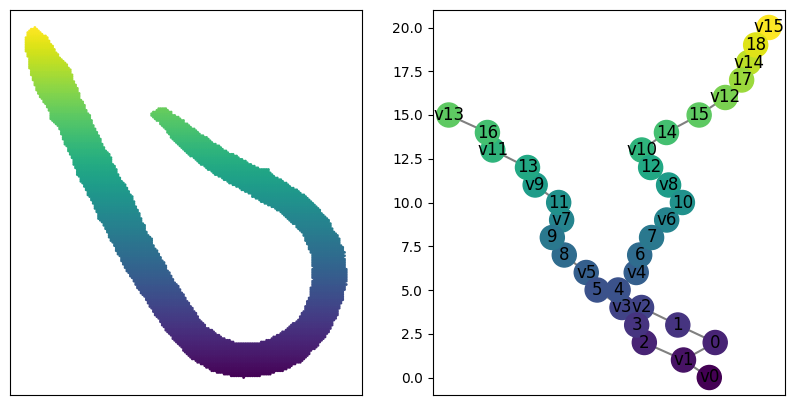

In [11]:
points = get_point_cloud_from_image("MPEG7_dataset/Seasnakes/sea_snake-1.gif", rotate_angle=None)
G = image_kmapper(points)
G = normalize_node_heihgts(G)
mapperG = our_mapper(G)

# Extract y-values (second column of points) for color mapping
y_values = points[:, 1]


fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot the point cloud
ax[0].scatter(points[:, 0], points[:, 1], c= y_values, s=1)
#remove the axis numbers
ax[0].set_xticks([])
ax[0].set_yticks([])


mapperG.draw(ax=ax[1])
plt.savefig("cup_mapper.png", dpi=300)
plt.show()

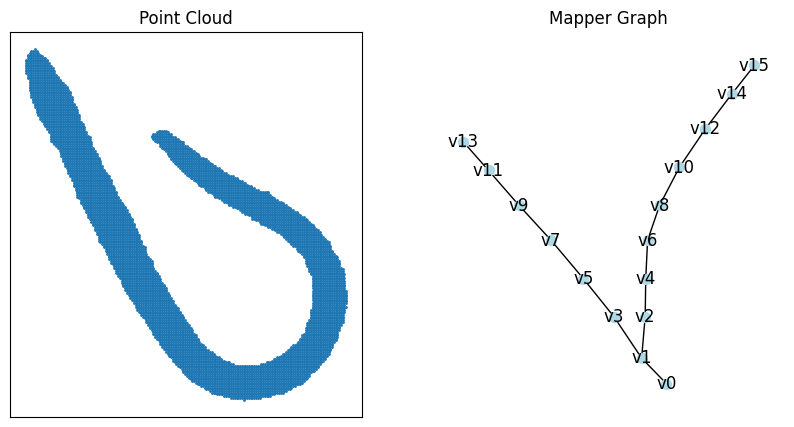

<Figure size 640x480 with 0 Axes>

In [12]:
plot_image_and_mapper(G, points, mapperG, save_fig=True )

In [541]:
import pickle

SAVE_FILE = "interleave_results.pkl"

def load_results():
    """Load saved interleave results."""
    if os.path.exists(SAVE_FILE):
        with open(SAVE_FILE, "rb") as f:
            return pickle.load(f)
    return {}

# Load and print the results
results = load_results()
print(len(results))  # Prints the number of saved results
print(results)  # Prints the entire dictionary

1275
{('apple1', 'apple1'): 0, ('apple1', 'apple2'): 0, ('apple1', 'apple3'): 1, ('apple1', 'apple4'): 1, ('apple1', 'apple5'): 1, ('apple1', 'apple6'): 0, ('apple1', 'apple7'): 1, ('apple1', 'apple8'): 0, ('apple1', 'apple9'): 0, ('apple1', 'apple10'): 1, ('apple1', 'cup1'): 5, ('apple1', 'cup2'): 5, ('apple1', 'cup3'): 6, ('apple1', 'cup4'): 2, ('apple1', 'cup5'): 3, ('apple1', 'cup6'): 3, ('apple1', 'cup7'): 3, ('apple1', 'cup8'): 5, ('apple1', 'cup9'): 5, ('apple1', 'cup10'): 6, ('apple1', 'fork1'): 2, ('apple1', 'fork2'): 3, ('apple1', 'fork3'): 4, ('apple1', 'fork4'): 3, ('apple1', 'fork5'): 3, ('apple1', 'fork6'): 2, ('apple1', 'fork7'): 2, ('apple1', 'fork8'): 3, ('apple1', 'fork9'): 3, ('apple1', 'fork10'): 3, ('apple1', 'horseshoe1'): 8, ('apple1', 'horseshoe2'): 9, ('apple1', 'horseshoe3'): 9, ('apple1', 'horseshoe4'): 8, ('apple1', 'horseshoe5'): 7, ('apple1', 'horseshoe6'): 7, ('apple1', 'horseshoe7'): 7, ('apple1', 'horseshoe8'): 8, ('apple1', 'horseshoe9'): 8, ('apple1',

In [14]:
apple_files = ["MPEG7_dataset/Apples/apple-1.gif",
               "MPEG7_dataset/Apples/apple-2.gif",
               "MPEG7_dataset/Apples/apple-3.gif",
               "MPEG7_dataset/Apples/apple-4.gif",
               "MPEG7_dataset/Apples/apple-5.gif",
               "MPEG7_dataset/Apples/apple-6.gif",
               "MPEG7_dataset/Apples/apple-7.gif",
               "MPEG7_dataset/Apples/apple-8.gif",
               "MPEG7_dataset/Apples/apple-10.gif",
               "MPEG7_dataset/Apples/apple-11.gif"]

cup_files_without_join = ["MPEG7_dataset/Cups/cup-11.gif",
                          "MPEG7_dataset/Cups/cup-12.gif",
                          "MPEG7_dataset/Cups/cup-18.gif"]

cup_files_with_join = ["MPEG7_dataset/Cups/cup-8.gif",
                        "MPEG7_dataset/Cups/cup-9.gif",
                       "MPEG7_dataset/Cups/cup-7.gif",
                       "MPEG7_dataset/Cups/cup-4.gif",
                       "MPEG7_dataset/Cups/cup-1.gif",
                       "MPEG7_dataset/Cups/cup-19.gif",
                       "MPEG7_dataset/Cups/cup-20.gif"]

cup_files = cup_files_without_join + cup_files_with_join

crown_files = ["MPEG7_dataset/Crowns/crown-1.gif",
               "MPEG7_dataset/Crowns/crown-2.gif",
               "MPEG7_dataset/Crowns/crown-3.gif",
               "MPEG7_dataset/Crowns/crown-4.gif",
               "MPEG7_dataset/Crowns/crown-6.gif",
               "MPEG7_dataset/Crowns/crown-7.gif",
               "MPEG7_dataset/Crowns/crown-13.gif",
               "MPEG7_dataset/Crowns/crown-16.gif",
               "MPEG7_dataset/Crowns/crown-17.gif",
               "MPEG7_dataset/Crowns/crown-19.gif"]




fork_files = ["MPEG7_dataset/Forks/fork-1.gif",
                "MPEG7_dataset/Forks/fork-2.gif",
                "MPEG7_dataset/Forks/fork-3.gif",
                "MPEG7_dataset/Forks/fork-4.gif",
                "MPEG7_dataset/Forks/fork-5.gif",
                "MPEG7_dataset/Forks/fork-6.gif",
                "MPEG7_dataset/Forks/fork-7.gif",
                "MPEG7_dataset/Forks/fork-8.gif",
                "MPEG7_dataset/Forks/fork-16.gif",
                "MPEG7_dataset/Forks/fork-15.gif"]


horseshoes_files = ["MPEG7_dataset/Horseshoes/horseshoe-1.gif",
                    "MPEG7_dataset/Horseshoes/horseshoe-2.gif",
                    "MPEG7_dataset/Horseshoes/horseshoe-3.gif",
                    "MPEG7_dataset/Horseshoes/horseshoe-20.gif",
                    "MPEG7_dataset/Horseshoes/horseshoe-13.gif",
                    "MPEG7_dataset/Horseshoes/horseshoe-6.gif",
                    "MPEG7_dataset/Horseshoes/horseshoe-7.gif",
                    "MPEG7_dataset/Horseshoes/horseshoe-8.gif",
                    "MPEG7_dataset/Horseshoes/horseshoe-9.gif",
                    "MPEG7_dataset/Horseshoes/horseshoe-10.gif"]


deer_files = ["MPEG7_dataset/Deers/deer-1.gif",
                "MPEG7_dataset/Deers/deer-2.gif",
                "MPEG7_dataset/Deers/deer-3.gif",
                "MPEG7_dataset/Deers/deer-4.gif",
                "MPEG7_dataset/Deers/deer-5.gif",
                "MPEG7_dataset/Deers/deer-6.gif",
                "MPEG7_dataset/Deers/deer-7.gif",
                "MPEG7_dataset/Deers/deer-8.gif",
                "MPEG7_dataset/Deers/deer-9.gif",
                "MPEG7_dataset/Deers/deer-10.gif"]

octopus_files = ["MPEG7_dataset/Octopi/octopus-1.gif",
                "MPEG7_dataset/Octopi/octopus-2.gif",
                "MPEG7_dataset/Octopi/octopus-20.gif",
                "MPEG7_dataset/Octopi/octopus-4.gif",
                "MPEG7_dataset/Octopi/octopus-5.gif",
                "MPEG7_dataset/Octopi/octopus-6.gif",
                "MPEG7_dataset/Octopi/octopus-7.gif",
                "MPEG7_dataset/Octopi/octopus-8.gif",
                "MPEG7_dataset/Octopi/octopus-9.gif",
                "MPEG7_dataset/Octopi/octopus-10.gif"]

seasnake_files = ["MPEG7_dataset/Seasnakes/sea_snake-1.gif",
                "MPEG7_dataset/Seasnakes/sea_snake-2.gif",
                "MPEG7_dataset/Seasnakes/sea_snake-3.gif",
                "MPEG7_dataset/Seasnakes/sea_snake-4.gif",
                "MPEG7_dataset/Seasnakes/sea_snake-11.gif",
                "MPEG7_dataset/Seasnakes/sea_snake-6.gif",
                "MPEG7_dataset/Seasnakes/sea_snake-7.gif",
                "MPEG7_dataset/Seasnakes/sea_snake-8.gif",
                "MPEG7_dataset/Seasnakes/sea_snake-20.gif",
                "MPEG7_dataset/Seasnakes/sea_snake-10.gif"]

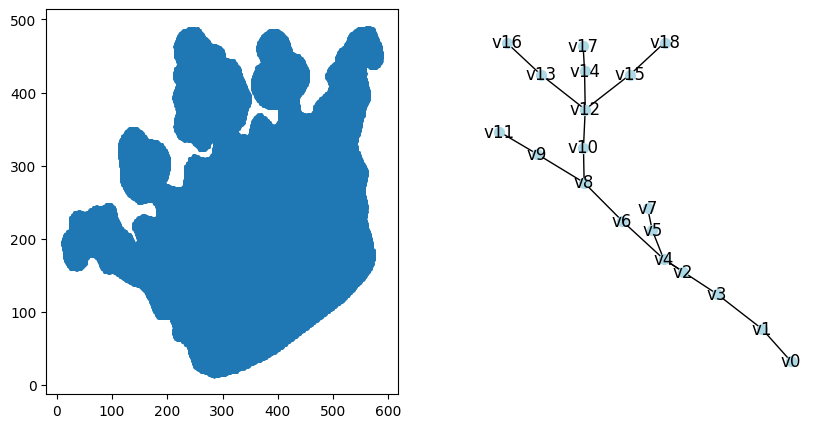

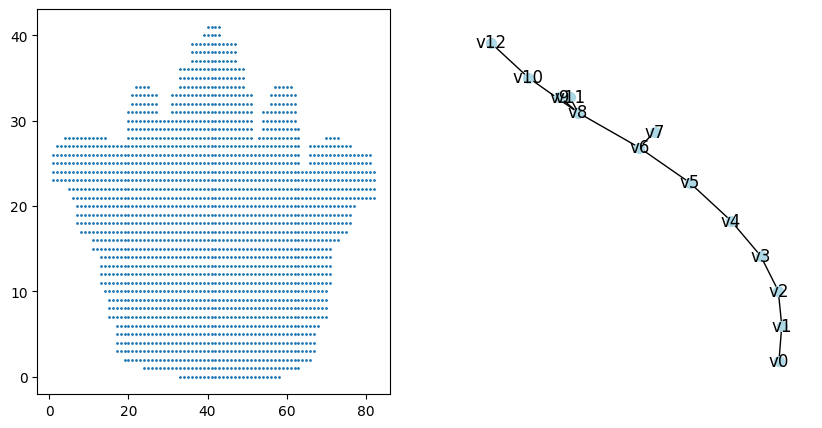

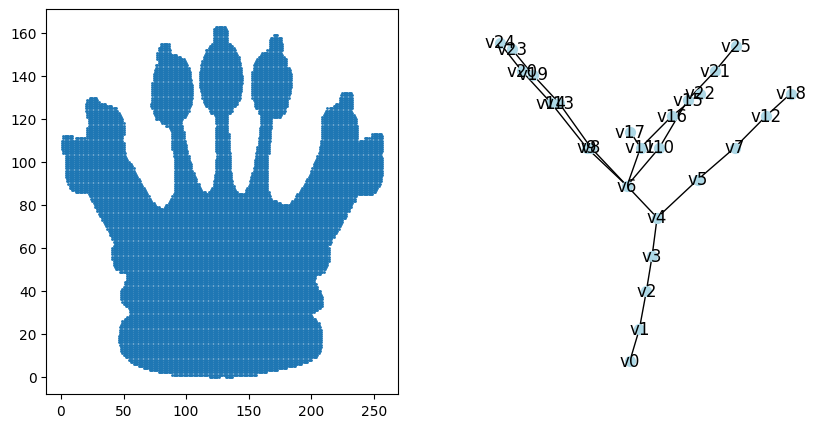

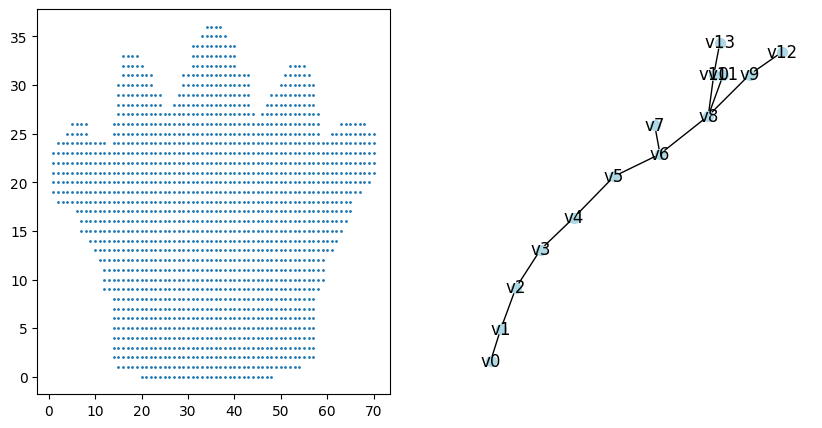

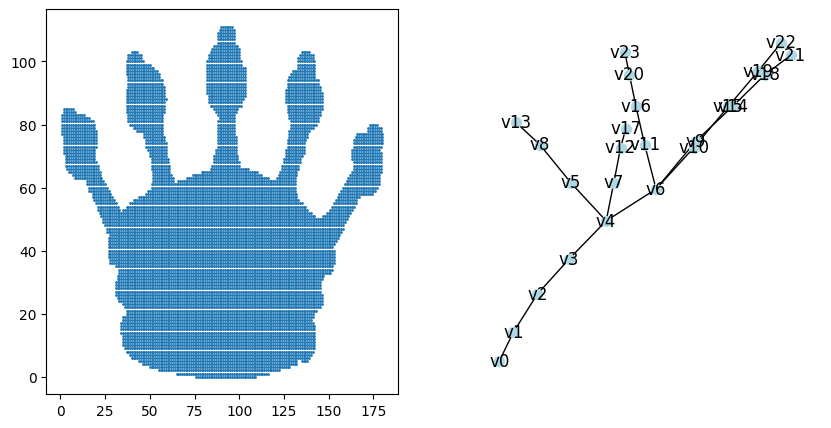

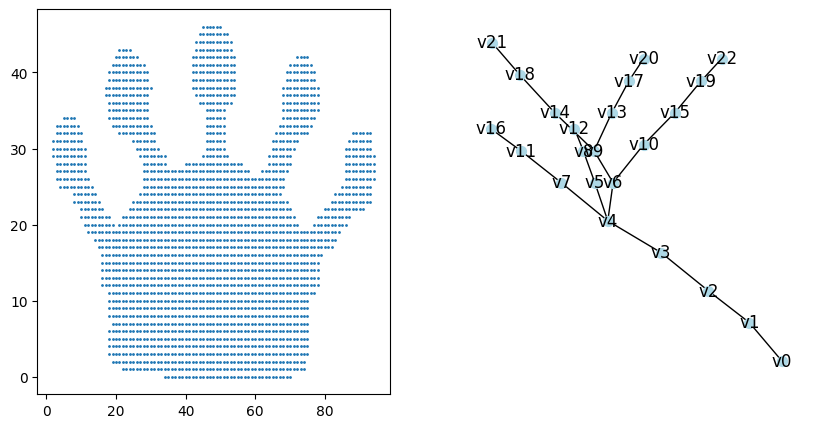

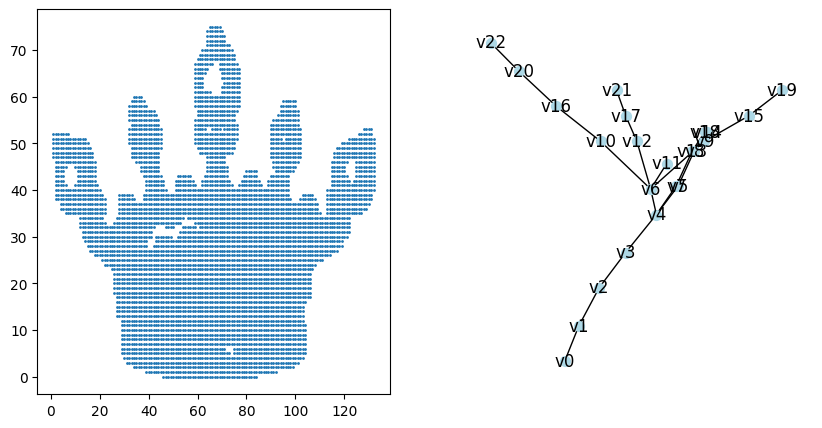

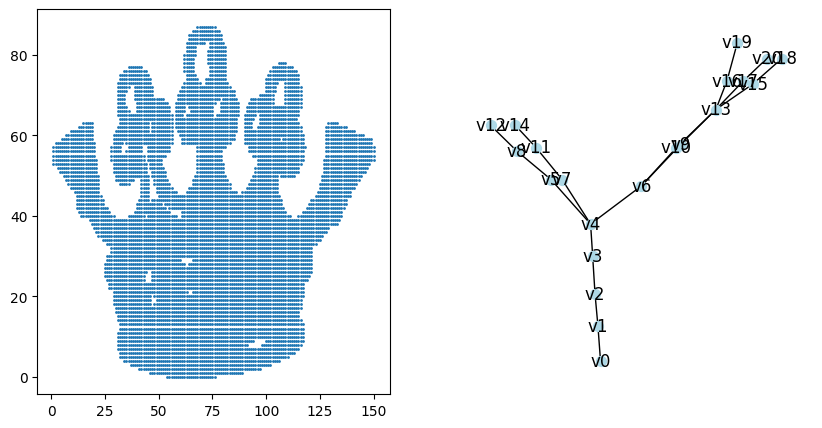

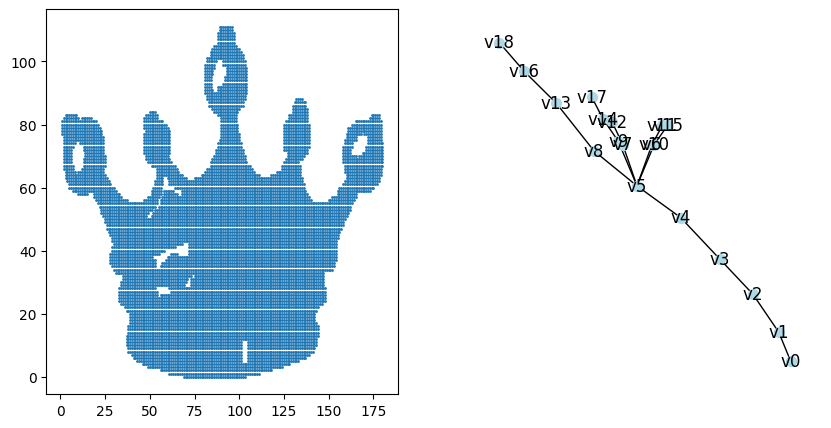

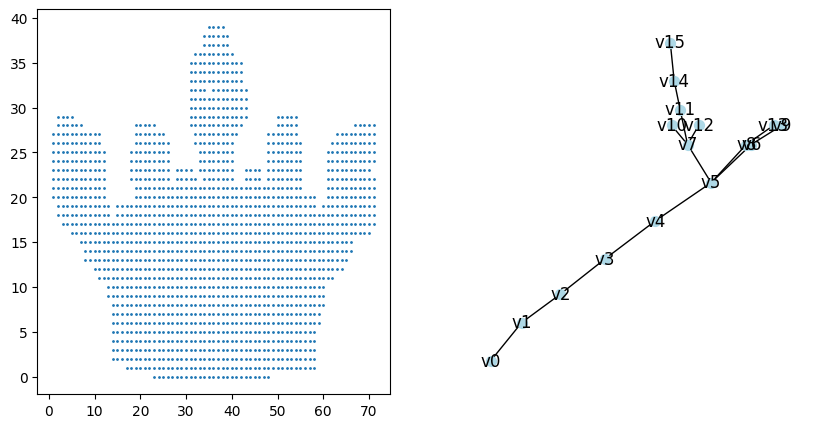

In [19]:
for i in range(10):
    save_rotated_image(crown_files[i], 90)
    points = get_point_cloud_from_image(crown_files[i], rotate_angle=0)
    G = image_kmapper(points)
    G = normalize_node_heihgts(G)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # plot mapperh
    pos = nx.spring_layout(G)
    for node_id in G.nodes:
        if 'fx' in G.nodes[node_id]:  # Ensure 'fx' exists
            pos[node_id][1] = G.nodes[node_id]['fx']

    # check if G has more than one connected component
    if nx.number_connected_components(G) > 1:
        print(f"Image {crown_files[i]} has more than one connected component")
        continue
    # Plot the point cloud
    ax[0].scatter(points[:, 0], points[:, 1], s=1)

    nx.draw(G, pos=pos, node_size=50, with_labels=True, font_size=12,
        node_color='lightblue', ax=ax[1])
    ax[1].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax[1].grid(True)  # Add a grid for better visualization

In [431]:
generate_mapper(cup_files[1])

In [432]:
apple_mappers = [generate_mapper(apple_files[i]) for i in range(10)]
cup_mappers = [generate_mapper(cup_files[i]) for i in range(10)]
fork_mappers = [generate_mapper(fork_files[i]) for i in range(10)]
horseshoe_mappers = [generate_mapper(horseshoes_files[i]) for i in range(10)]
seasnake_mappers = [generate_mapper(seasnake_files[i]) for i in range(10)]

In [434]:
apple_dicts = {i+1: apple_mappers[i] for i in range(len(apple_mappers))}
cup_dicts = {i+1: cup_mappers[i] for i in range(len(cup_mappers))}
fork_dicts = {i+1: fork_mappers[i] for i in range(len(fork_mappers))}
horseshoe_dicts = {i+1: horseshoe_mappers[i] for i in range(len(horseshoe_mappers))}
seasnake_dicts = {i+1: seasnake_mappers[i] for i in range(len(seasnake_mappers))}    

In [435]:
# create a large dataframe with apple0, apple1, apple2, ... cup0, cup1, cup2, ... and keep it empty
categories = ['apple', 'cup', 'crown', 'fork', 'horseshoe']

names = [categories[i]+ str(j+1) for i in range(len(categories)) for j in range(10)]

df = pd.DataFrame(index=names, columns=names)

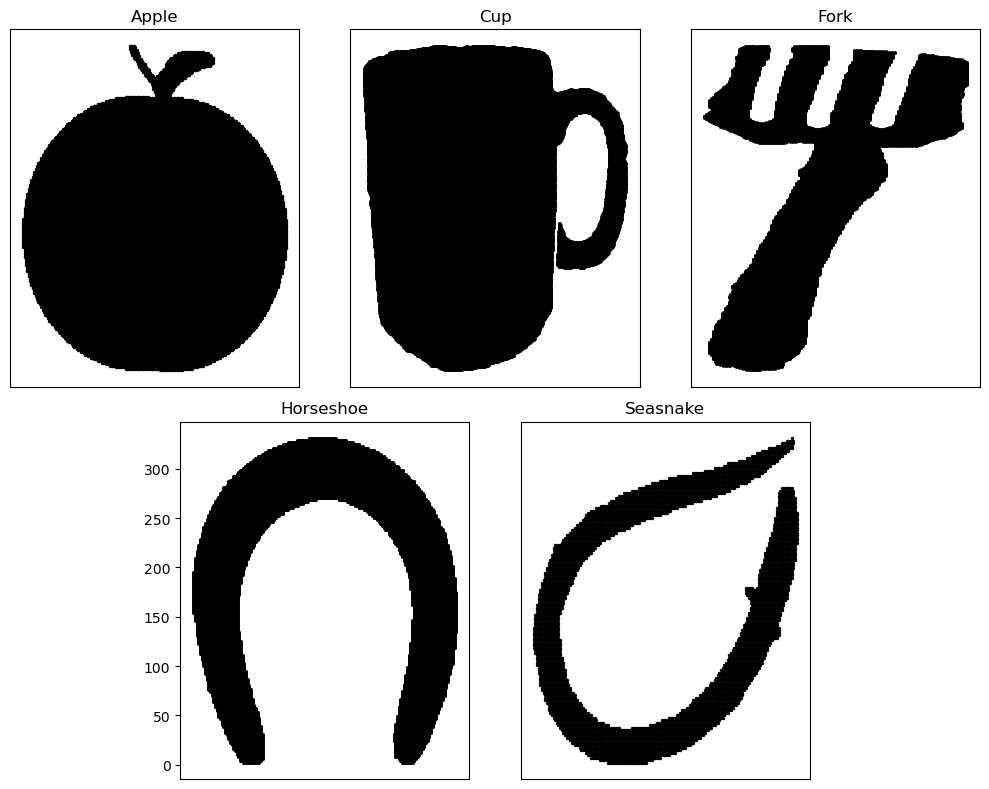

In [568]:
apple = apple_files[0]
cup = cup_files[7]
fork = fork_files[3]
horseshoe = horseshoes_files[0]
seasnake = seasnake_files[5]

# Create figure with the right size
fig = plt.figure(figsize=(10, 8))

# Create subplots using subplot2grid
ax1 = plt.subplot2grid(shape=(2, 6), loc=(0, 0), colspan=2)
ax2 = plt.subplot2grid(shape=(2, 6), loc=(0, 2), colspan=2)
ax3 = plt.subplot2grid(shape=(2, 6), loc=(0, 4), colspan=2)
ax4 = plt.subplot2grid(shape=(2, 6), loc=(1, 1), colspan=2)
ax5 = plt.subplot2grid(shape=(2, 6), loc=(1, 3), colspan=2)

# Get point clouds
apoints = get_point_cloud_from_image(apple, rotate_angle=0)
cpoints = get_point_cloud_from_image(cup, rotate_angle=0)
fpoints = get_point_cloud_from_image(fork, rotate_angle=0)
hpoints = get_point_cloud_from_image(horseshoe, rotate_angle=0)
spoints = get_point_cloud_from_image(seasnake, rotate_angle=0)

# Scatter plots (all black points)
ax1.scatter(apoints[:, 0], apoints[:, 1], s=2, color='black')  # or c='k'
ax1.set_title("Apple")
ax1.set_xticks([])
ax1.set_yticks([])

ax2.scatter(cpoints[:, 0], cpoints[:, 1], s=1, color='black')
ax2.set_title("Cup")
ax2.set_xticks([])
ax2.set_yticks([])

ax3.scatter(fpoints[:, 0], fpoints[:, 1], s=1, color='black')
ax3.set_title("Fork")
ax3.set_xticks([])
ax3.set_yticks([])

ax4.scatter(hpoints[:, 0], hpoints[:, 1], s=1, color='black')
ax4.set_title("Horseshoe")
ax4.set_xticks([])
ax4.set_yticks

ax5.scatter(spoints[:, 0], spoints[:, 1], s=2, color='black')
ax5.set_title("Seasnake")
ax5.set_xticks([])
ax5.set_yticks([])
plt.tight_layout()
plt.savefig("point_clouds.png", dpi=300)
plt.show()


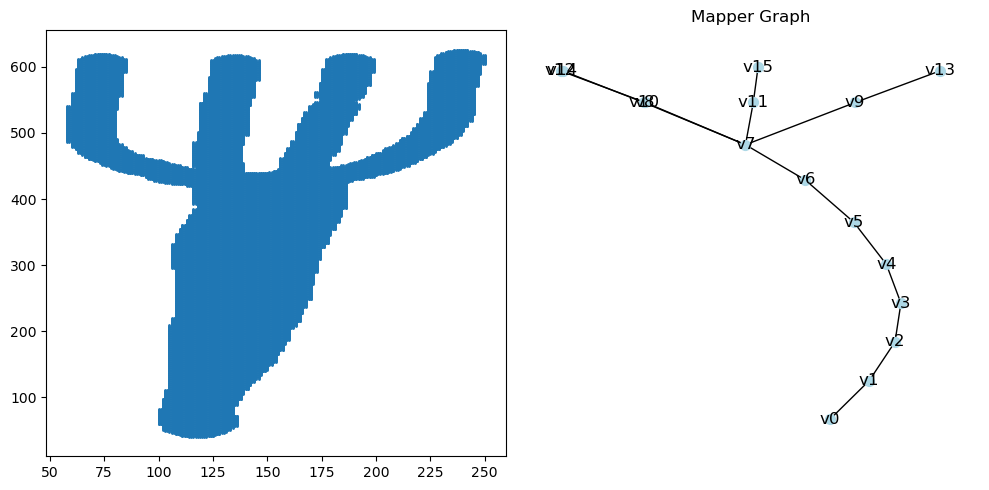

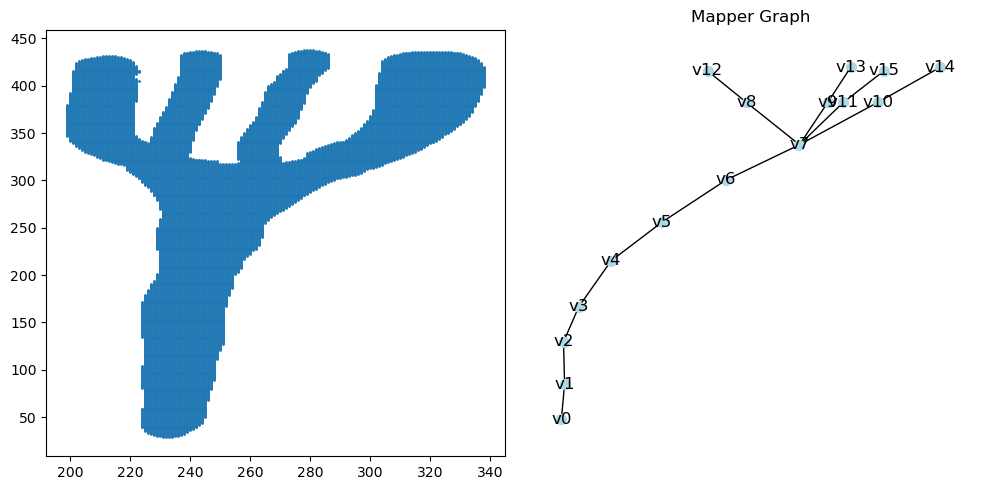

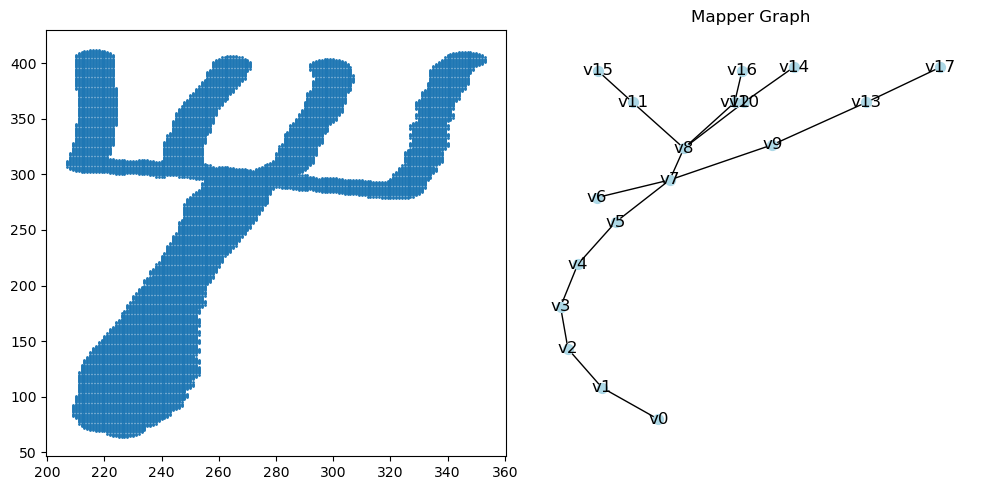

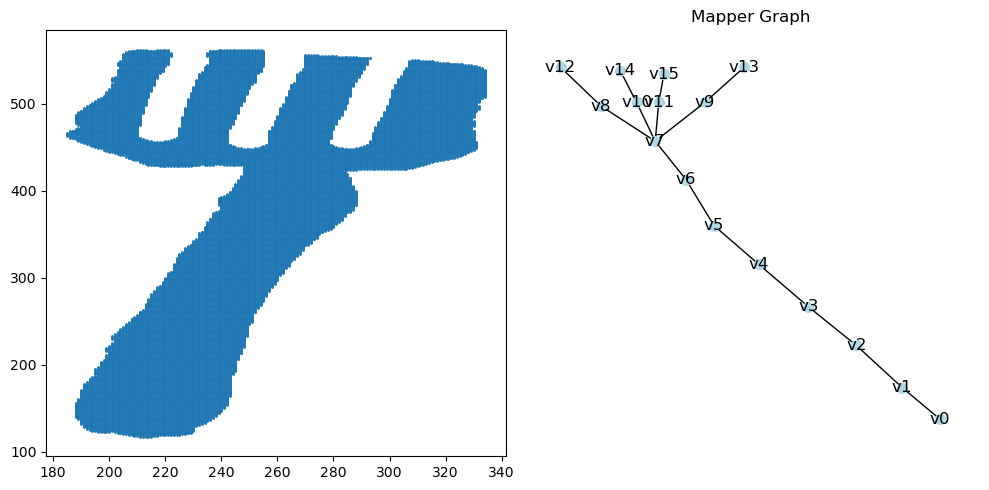

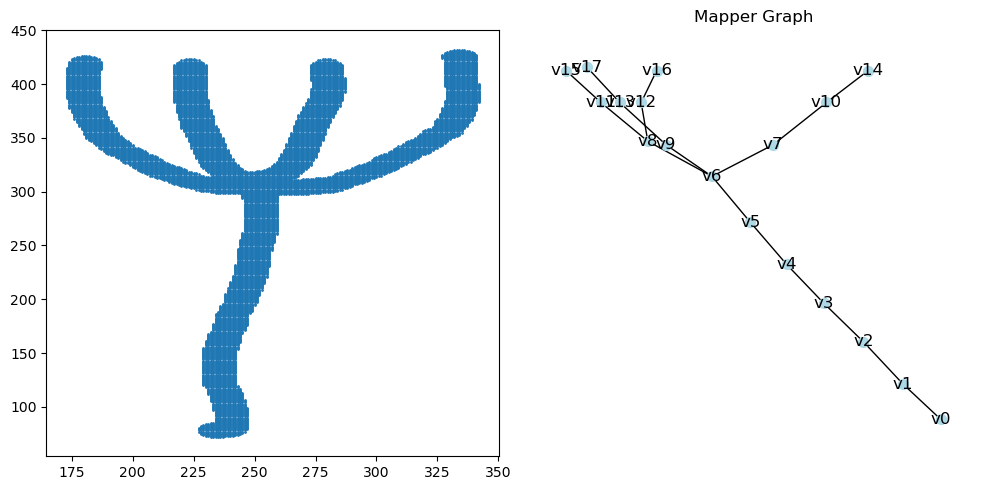

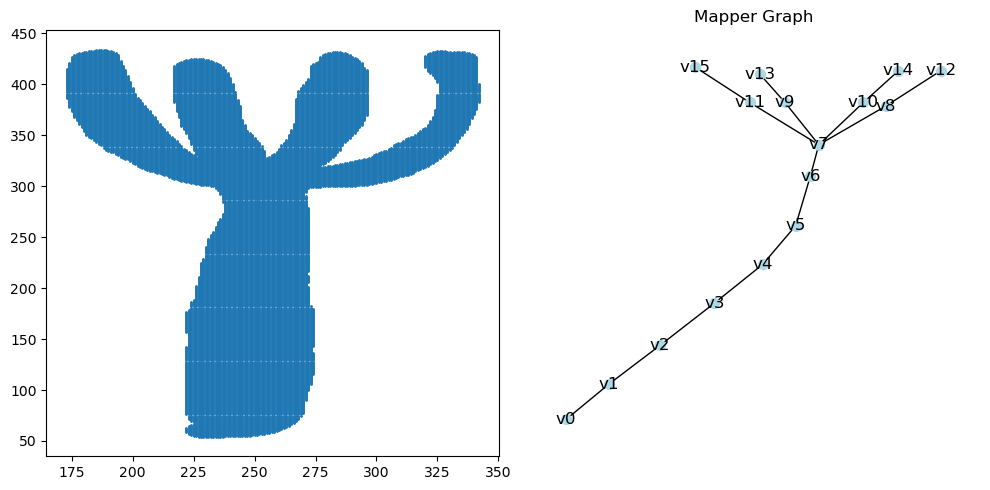

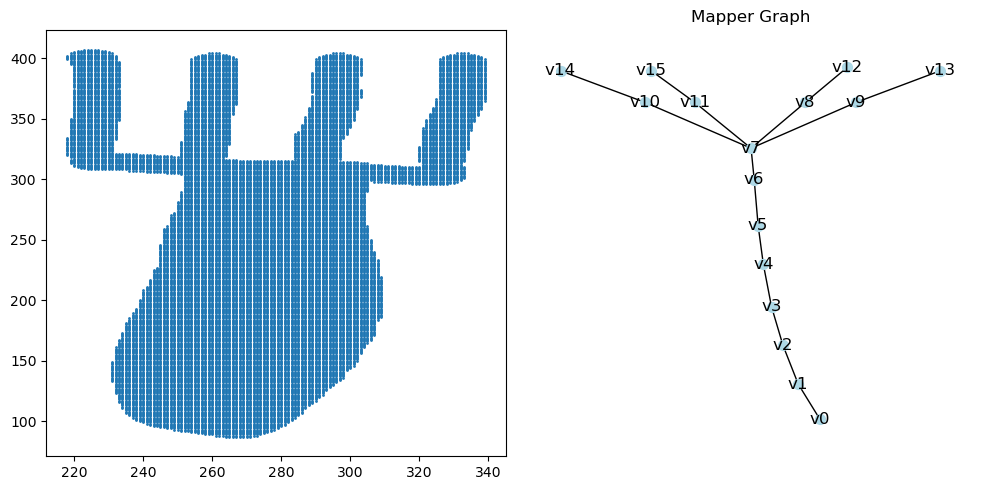

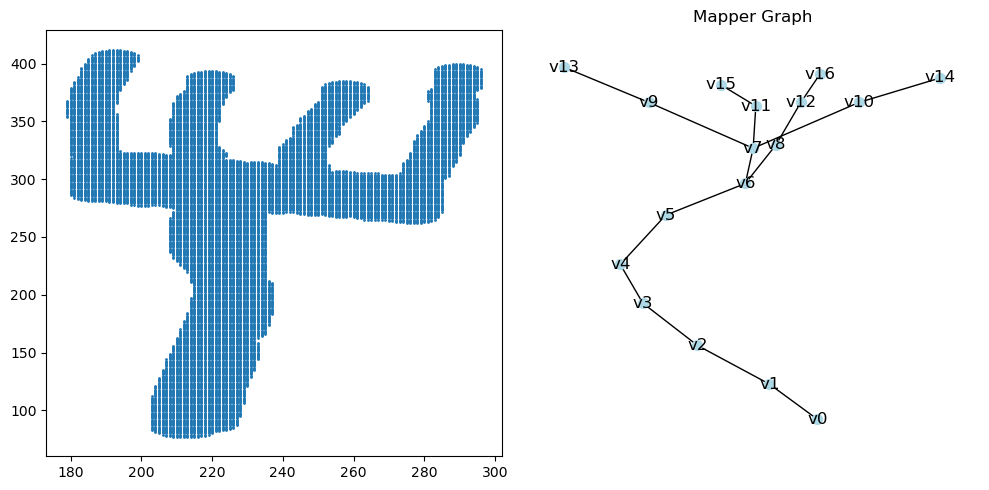

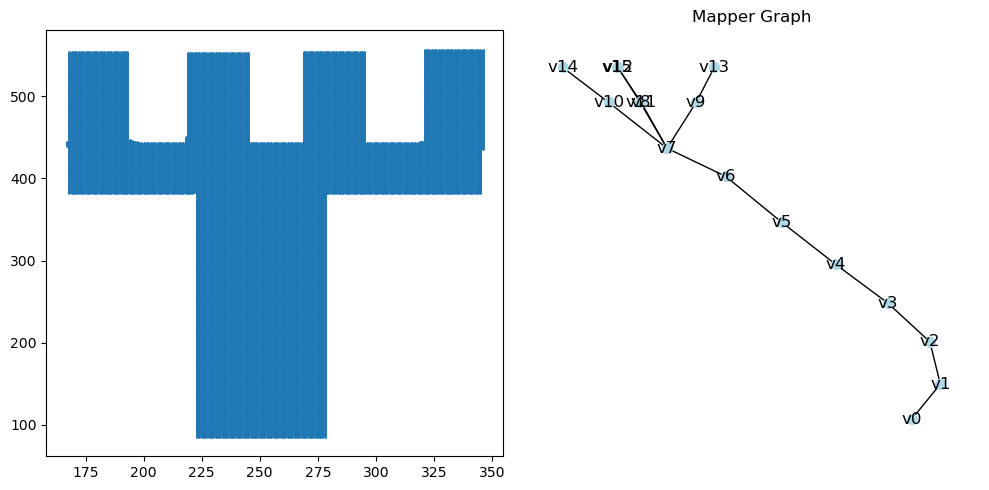

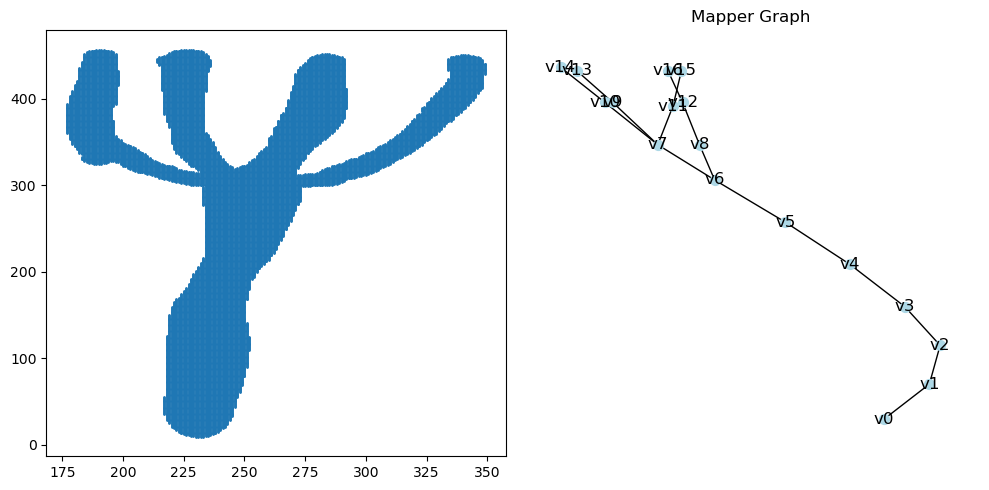

In [572]:
for i in range(10):
    points = get_point_cloud_from_image(fork_files[i], rotate_angle=0)  
    G = image_kmapper(points)
    G = normalize_node_heihgts(G)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    # plot mapperh
    pos = nx.spring_layout(G)
    for node_id in G.nodes:
        if 'fx' in G.nodes[node_id]:  # Ensure 'fx' exists
            pos[node_id][1] = G.nodes[node_id]['fx']
    # check if G has more than one connected component
    if nx.number_connected_components(G) > 1:
        print(f"Image {seasnake_files[i]} has more than one connected component")
        continue

    # Plot the point cloud
    ax[0].scatter(points[:, 0], points[:, 1], s=1)

    nx.draw(G, pos=pos, node_size=50, with_labels=True, font_size=12,
            node_color='lightblue', ax=ax[1])
    
    ax[1].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax[1].grid(True)  # Add a grid for better visualization
    ax[1].set_title("Mapper Graph")
    plt.tight_layout()
    